In [1]:
from __future__ import division
import scipy.io
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind
from mne.stats import fdr_correction

### 1. Load and preprocess data

#### Load data from .mat files

In [2]:
# Initialise empty dataframe
Total = pd.DataFrame()

# Loop over regions of interest
for roi in ['tf', 'hf', 'bf']:
    
    # Initialise empty dataframe
    TotalRoi = pd.DataFrame()
    
    # loop over all .mat files
    for f in glob.glob('dyads_MEA_data/**/*.mat'):
    
        # load file
        mat = scipy.io.loadmat(f)
        # extract filename from path
        filename = f.split('/')[1]
        # create dataframe with mRsq
        fileframe = pd.DataFrame(mat[roi]['mRsq'][0][0])
        fileframe.rename(columns={0:'mRsq'}, inplace=True)
        fileframe['Frequency'] = mat[roi]['per'][0][0].T
        # add dyad number and task (extracted from filename) as columns
        if filename.startswith('Pseudo'):
            fileframe['Dyad'] = 'Pseudo'
            fileframe['ID'] = filename.split('_')[1]
            fileframe['Task'] = filename.split('_')[3] + '_' + filename.split('_')[4]
        else:
            fileframe['Dyad'] = 'Real'
            fileframe['ID'] = filename.split('_')[0]
            fileframe['Task'] = filename.split('_')[2] + '_' + filename.split('_')[3]
        
        # concatenate fileframe to total dataframe
        TotalRoi = pd.concat([TotalRoi,fileframe])
        
    # add roi as column
    TotalRoi['ROI'] = roi
    
    # concatenate fileframe to total dataframe
    Total = pd.concat([Total,TotalRoi])
    
# drop the index (=Frequency) and add as column
Total.reset_index(drop=True,inplace=True)

#### Recode dyads to group

In [3]:
Total['Group'] = pd.np.where(Total['ID'].isin(['D13','D14','D15','D16','D17',
                                                'D18','D19','D20','D23','D26']),'TD',
                             pd.np.where(Total['ID'].isin(['D1','D2','D3','D4','D5',
                                                            'D6','D7','D8','D29','D30']),'ASD','Mixed'))

#### Calculate Frequency and log

In [4]:
Total['Frequency'] = pd.np.round(1./Total['Frequency'],3)

In [5]:
Total['Frequency (log)'] = pd.np.log2(Total['Frequency'])

#### Delete _neworder from task name and capitalise column

In [6]:
Total['Task'] = Total['Task'].str.replace('_neworder','')

In [7]:
Total['Task'] = Total['Task'].str.capitalize()

#### Recode ROI column

In [8]:
Total['ROI'] = Total['ROI'].replace({'tf':'Total','hf':'Head','bf':'Body'})

#### View dataframe

In [9]:
Total.head()

,mRsq,Frequency,Dyad,ID,Task,ROI,Group,Frequency (log)
0,0.361495,12.100,Real,D6,Island,Total,ASD,3.596935
1,0.332069,11.421,Real,D6,Island,Total,ASD,3.513617
2,0.303935,10.780,Real,D6,Island,Total,ASD,3.430285
3,0.278881,10.175,Real,D6,Island,Total,ASD,3.346957
4,0.256964,9.604,Real,D6,Island,Total,ASD,3.263635


### 2. Analysis

In [10]:
# Calculate average across tasks
task_average = (
    Total.groupby(['Frequency','Dyad','ID','ROI'])
         .agg({'mRsq':'mean',
               'Group':'last',
               'Frequency (log)':'last'})
         .reset_index(drop=False)
)

#### 2.1. Real vs. Pseudo Dyads

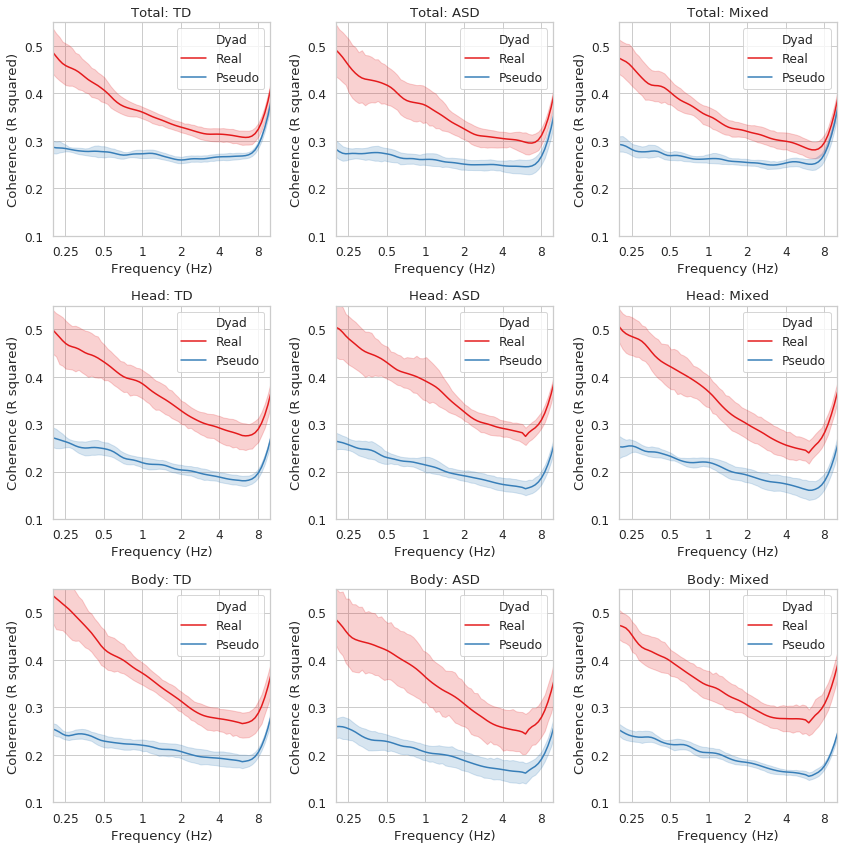

In [125]:
sns.set(font_scale=1.1, style='whitegrid', font= 'DejaVu Sans')
sns.set_palette('Set1')

for row, roi in enumerate(Total.ROI.unique()):
    
    for col, group in enumerate(['TD', 'ASD', 'Mixed']):
        plt.subplot(3,3,(col+1)+((row)*3))
        sns.lineplot(x="Frequency (log)", 
                     y="mRsq",
                     hue='Dyad',
                     hue_order=['Real','Pseudo'],
                     data=task_average[(task_average['Group'] == group) &
                                       (task_average['ROI'] == roi)])

        plt.xlim(pd.np.log2([0.2,10]))
        plt.ylim(0.1,0.55)
        plt.xticks(pd.np.log2([0.25, 0.5, 1, 2, 4, 8]), [0.25, 0.5, 1, 2, 4, 8])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Coherence (R squared)')
        plt.title(roi + ': ' + group)

fig = plt.gcf()
fig.set_size_inches(12,12)
plt.tight_layout()
fig.savefig('results/coherence_real_vs_pseudo_dyads.pdf')

#### 2.2. Group differences 

Calculate statistics

In [35]:
# Subset to frequencies of interest (min, max)
stats_df = task_average[task_average['Frequency'].between(0.2,8)]

In [37]:
# Define function to calculate Cohen's d ´
def cohen_d(x,y):
        return ((pd.np.mean(x) - pd.np.mean(y)) / 
                pd.np.sqrt((pd.np.std(x, ddof=1) ** 2 + pd.np.std(y, ddof=1) ** 2) / 2.0))

In [81]:
# initialise lists
freqs = []; ts = []; ps = []; cs = []; rois = []; comps = []
comparison = [['TD','ASD'], ['TD','Mixed'], ['ASD','Mixed']]

# loop over ROIs
for roi in stats_df.ROI.unique():
    
    # loop over comparison
    for c in comparison:

        # loop over freq
        for freq in stats_df.Frequency.unique():

            # calculate t-test
            t, p = ttest_ind(stats_df[(stats_df['Frequency']==freq) & 
                                      (stats_df['Group']==c[0]) & 
                                      (stats_df['ROI']==roi)].mRsq,
                             stats_df[(stats_df['Frequency']==freq) & 
                                      (stats_df['Group']==c[1]) & 
                                      (stats_df['ROI']==roi)].mRsq, 
                             equal_var=False)

            # calculate cohen's d
            cohen = cohen_d(stats_df[(stats_df['Frequency']==freq) & 
                                     (stats_df['Group']==c[0]) & 
                                     (stats_df['ROI']==roi)].mRsq,
                            stats_df[(stats_df['Frequency']==freq) & 
                                     (stats_df['Group']==c[1]) & 
                                     (stats_df['ROI']==roi)].mRsq)
            
            # add to lists
            ts.append(t)
            ps.append(p)
            cs.append(cohen)
            rois.append(roi)
            freqs.append(pd.np.log2(freq))
            comps.append(c[0] + ' vs ' + c[1])
    
# list to dataframe
stats = pd.DataFrame({'Frequency': freqs,
                      'Comparison': comps,
                      'ROI': rois,
                      't': ts,
                      'p': ps,
                      'd': cs})

In [82]:
# FDR correction for p values
fdr = []; 

for roi in stats.ROI.unique():
    
    for comp in stats.Comparison.unique():
        
        fdr.extend(fdr_correction(alpha=0.05,
                                  pvals=stats.loc[(stats['ROI']==roi) & 
                                                  (stats['Comparison']==comp), 'p'])[1][:])

stats['fdr'] = fdr

In [131]:
# Significance flags
stats['Significance'] = pd.np.where(stats['p'] < 0.05,'*','ns.')
stats['Significance (FDR)'] = pd.np.where(stats['fdr'] < 0.05,'*','ns.')

Plot effect sizes

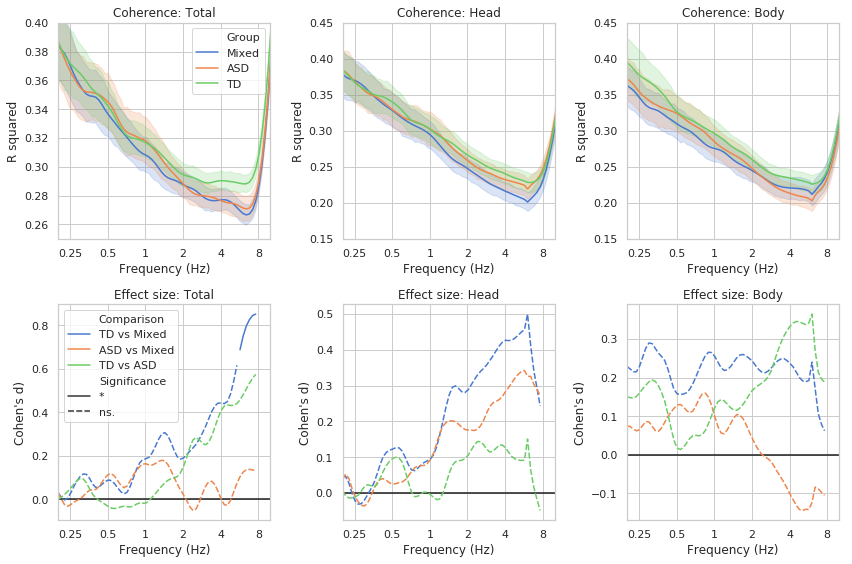

In [140]:
sns.set(font_scale=1, style='whitegrid', font= 'DejaVu Sans')
sns.set_palette('muted')

for col, roi in enumerate(Total.ROI.unique()):
    
    plt.subplot(2,3, col+1)
    sns.lineplot(x="Frequency (log)", 
                 y="mRsq",
                 hue='Group',  
                 hue_order=['Mixed','ASD','TD'],
                 data=Total[Total['ROI']==roi])
    plt.xlim(pd.np.log2([0.2,10]))
    if col==0:
        plt.ylim(0.25,0.4)
    else:
        plt.ylim(0.15,0.45)
    plt.xticks(pd.np.log2([0.25, 0.5, 1, 2, 4, 8]), [0.25, 0.5, 1, 2, 4, 8])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('R squared')
    plt.title('Coherence: ' + roi)
    if col>0:
        plt.gca().get_legend().remove()
    
    plt.subplot(2,3, col+4)
    sns.lineplot(x='Frequency',dashes=True,
             y='d', 
             hue='Comparison', 
             style='Significance',
             style_order=['*','ns.'],
             hue_order=['TD vs Mixed', 'ASD vs Mixed', 'TD vs ASD'],
             data=stats[stats.ROI==roi])
    plt.xlim(pd.np.log2([0.2,10]))
    plt.xticks(pd.np.log2([0.25, 0.5, 1, 2, 4, 8]), [0.25, 0.5, 1, 2, 4, 8])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel("Cohen's d)")
    plt.title('Effect size: ' + roi);
    plt.hlines(y=0, xmin=-3, xmax=8)
    if col>0:
        plt.gca().get_legend().remove()

fig =plt.gcf()
fig.set_size_inches(12, 8)
plt.tight_layout()
fig.savefig('results/coherence_TD_vs_ASD_vs_Mixed.pdf')

#### 2.3. Individual tasks

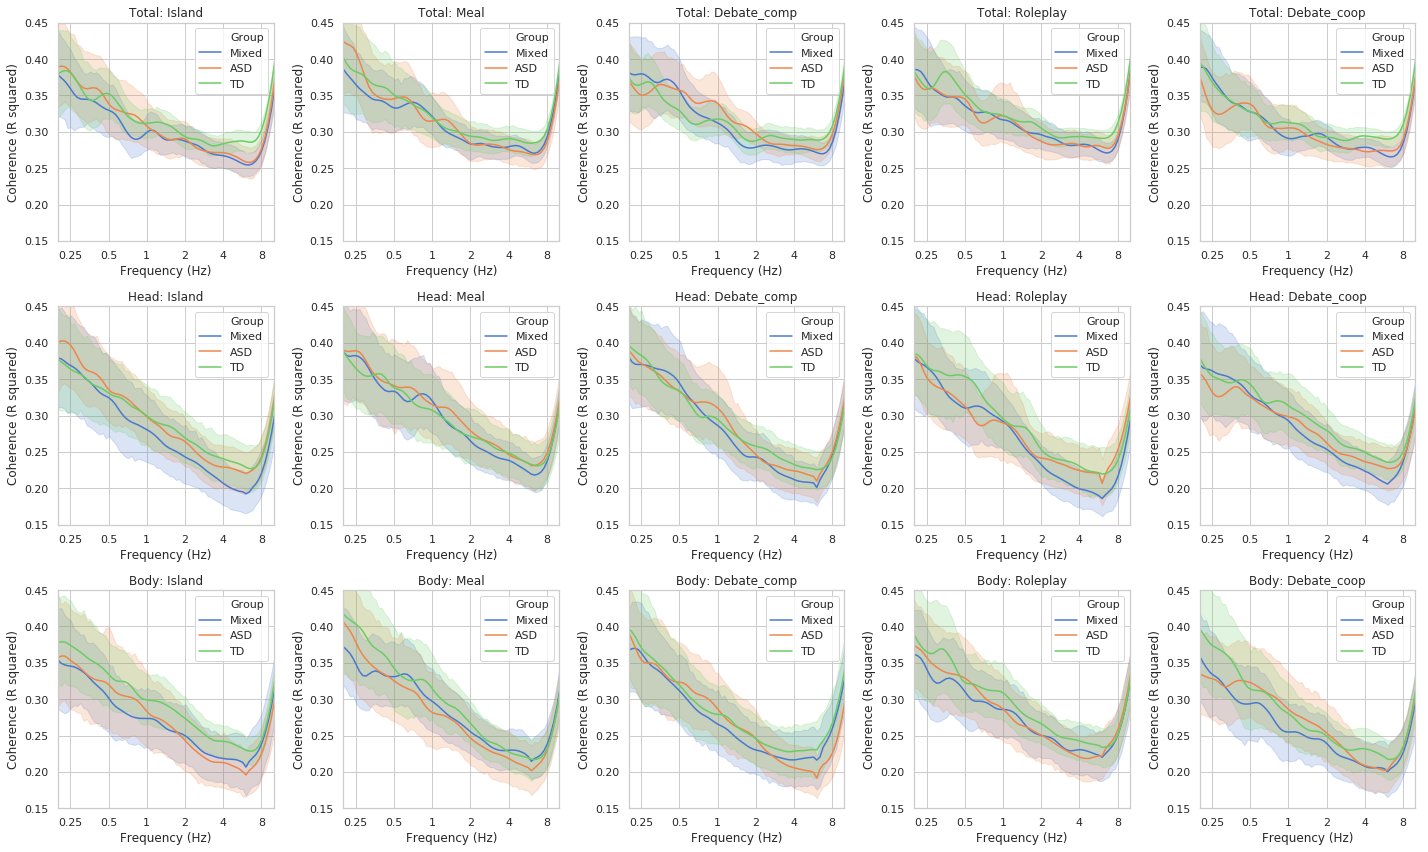

In [149]:
sns.set(font_scale=1, style='whitegrid', font= 'DejaVu Sans')
sns.set_palette('muted')

for row, roi in enumerate(Total.ROI.unique()):
    
    for col, task in enumerate(Total.Task.unique()):
        
        plt.subplot(3,5,(col+1)+((row)*5))
        sns.lineplot(x="Frequency (log)", 
                     y="mRsq",
                     hue='Group',
                     hue_order=['Mixed','ASD','TD'],
                     data=Total[(Total['Task']==task) & (Total['ROI']==roi)])

        plt.xlim(pd.np.log2([0.2,10]))
        plt.ylim(0.15,0.45)
        plt.xticks(pd.np.log2([0.25, 0.5, 1, 2, 4, 8]), [0.25, 0.5, 1, 2, 4, 8])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Coherence (R squared)')
        plt.title(roi + ': ' + task)

fig = plt.gcf()
fig.set_size_inches(20,12)
plt.tight_layout()
fig.savefig('results/coherence_individual_tasks.pdf')